**Download the dataset and annotations**

Download all the images and annotations for cars dataset from [ this link](https://ai.stanford.edu/~jkrause/cars/car_dataset.html).

In [2]:
!wget http://imagenet.stanford.edu/internal/car196/car_ims.tgz
!wget http://imagenet.stanford.edu/internal/car196/cars_annos.mat

--2019-06-17 15:46:28--  http://imagenet.stanford.edu/internal/car196/car_ims.tgz
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1956628579 (1.8G) [application/x-gzip]
Saving to: ‘car_ims.tgz’

car_ims.tgz         100%[===================>]   1.82G  51.7MB/s    in 47s     

2019-06-17 15:47:15 (39.6 MB/s) - ‘car_ims.tgz’ saved [1956628579/1956628579]

--2019-06-17 15:47:17--  http://imagenet.stanford.edu/internal/car196/cars_annos.mat
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 394471 (385K) [text/plain]
Saving to: ‘cars_annos.mat’

cars_annos.mat      100%[===================>] 385.23K  1.38MB/s    in 0.3s    

2019-06-17 15:47:17 (1.38 MB/s) - ‘

**Unpack the cars dataset**

In [3]:
import tarfile

print("Extracting the files...")
tf = tarfile.open("car_ims.tgz")
tf.extractall("Cars_Images/")
print("Finished...")

Extracting the files...
Finished...


**Import required libraries to create dataset**

In [0]:
from matplotlib import pyplot as plt

from scipy import io

import pandas as pd
import numpy as np

import cv2 as cv

import os

from fastai.vision import *
from fastai.callbacks import SaveModelCallback

**Create data**

This will separate all the data into train and test folder.

Also crop the images on bounding boxes given in the annotation file.

In [0]:
mat = io.loadmat("cars_annos.mat")
annot = mat['annotations'][0]

x1 = []
y1 = []
x2 = []
y2 = []

for i in range(len(annot)):
  
  x1.append(int(annot[i][1]))
  x2.append(int(annot[i][3]))
  y1.append(int(annot[i][2]))
  y2.append(int(annot[i][4]))

try:
  os.mkdir("data")
  os.mkdir("data/train")
  os.mkdir("data/test")
except FileExistsError:
  pass

train_img_name = []
train_lbl = []
test_img_name = []
test_lbl = []

for i in range(len(annot)):
  
  image_name = annot[i][0][0].split("/")[1]
  label = int(annot[i][5])
  
  img = cv.imread("Cars_Images/car_ims/"+image_name)
  
  x_1 = x1[i]
  y_1 = y1[i]
  x_2 = x2[i]
  y_2 = y2[i]
  
  new_img = img[y_1:y_2, x_1:x_2]
  
  flag = int(annot[i][6])
  
  if flag == 0:
    cv.imwrite("data/train/"+image_name, new_img)
    train_img_name.append(image_name)
    train_lbl.append(label)
  else:
    cv.imwrite("data/test/"+image_name, new_img)
    test_img_name.append(image_name)
    test_lbl.append(label)
    
train_csv = pd.DataFrame({'image_names':train_img_name, 'labels':train_lbl})
test_csv = pd.DataFrame({'image_names':test_img_name, 'labels':test_lbl})

train_csv.to_csv("data/train.csv", index=False)

**Helper Function**

get_data(size) --> This will create ImageDataBunch of the given size

train_model(size, i) --> performs couples of operation neccessary to train the classifier

In [0]:
def get_data(size):
  
  """ Creates ImageDataBunch
  """
  
  data = ImageDataBunch.from_csv(path="data/", folder="train",
                              csv_labels="train.csv", test="test",
                              ds_tfms=get_transforms(), size=size, bs=32)
  data.normalize(imagenet_stats)
  return data

In [0]:
def train_model(size, i):
  
  """ Training procedure
  """
  
  learn_50 = cnn_learner(get_data(size), models.resnet50, metrics=[error_rate, accuracy]).load('resnet50_'+str(size))
  learn_50.fit_one_cycle(5*i)
  learn_50.lr_find()
  learn_50.recorder.plot()
  learn_50.unfreeze()
  learn_50.fit_one_cycle(2*i)
  learn_50.save('resnet50_'+str(size))

**Training the model**

first with 64x64 image size, then increasing the image size on top of the previous image size upto 512x512.

In [12]:
learn_50 = cnn_learner(get_data(64), models.resnet50, metrics=[error_rate, accuracy])
learn_50.save("resnet50_64")
learn_50 = cnn_learner(get_data(128), models.resnet50, metrics=[error_rate, accuracy]).load('resnet50_64')
learn_50.save("resnet50_128")
learn_50 = cnn_learner(get_data(256), models.resnet50, metrics=[error_rate, accuracy]).load('resnet50_128')
learn_50.save("resnet50_256")
learn_50 = cnn_learner(get_data(512), models.resnet50, metrics=[error_rate, accuracy]).load('resnet50_256')
learn_50.save("resnet50_512")

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 91415276.10it/s]


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,5.052313,4.350764,0.896192,0.103808,02:02
1,4.124435,3.496014,0.773956,0.226044,01:54
2,3.445970,2.989603,0.698403,0.301597,01:55
3,2.971145,2.678453,0.634521,0.365479,01:55
4,2.589403,2.632483,0.625307,0.374693,01:55


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.126970,2.668636,0.657862,0.342138,01:58
1,2.018221,1.626520,0.442260,0.557740,01:58


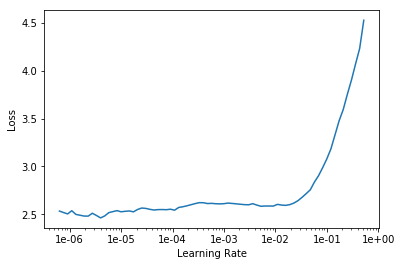

In [13]:
train_model(64, 1)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,5.295947,4.683789,0.932432,0.067568,01:53
1,4.433463,3.958615,0.852580,0.147420,01:54
2,3.852269,3.395504,0.770885,0.229115,01:54
3,3.301471,2.877181,0.681818,0.318182,01:54
4,2.915134,2.614899,0.650491,0.349509,01:54
5,2.565059,2.355344,0.597052,0.402948,01:54
6,2.275221,2.171326,0.545455,0.454545,01:54
7,2.081290,2.060456,0.520270,0.479730,01:54
8,1.916876,2.009827,0.510442,0.489558,01:54
9,1.841826,2.002174,0.505528,0.494472,01:55


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.584169,2.622282,0.646806,0.353194,01:58
1,2.467583,1.966666,0.509214,0.490786,01:58
2,1.597452,1.247243,0.340909,0.659091,01:59
3,0.991305,1.045345,0.280713,0.719287,01:57


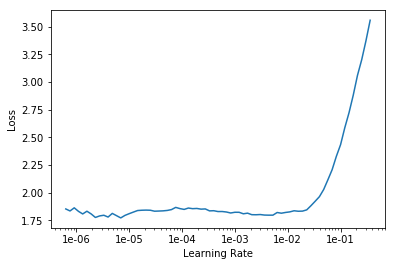

In [14]:
train_model(128, 2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,5.427066,4.806027,0.939803,0.060197,01:54
1,4.628577,4.106707,0.859337,0.140663,01:55
2,4.041139,3.533959,0.788084,0.211916,01:55
3,3.614119,3.093026,0.725430,0.274570,01:54
4,3.181630,2.753568,0.672604,0.327396,01:54
5,2.833230,2.478021,0.608722,0.391278,01:54
6,2.498350,2.300645,0.568796,0.431204,01:54
7,2.244207,2.109787,0.528256,0.471744,01:55
8,2.105837,1.978475,0.490172,0.509828,01:55
9,1.889432,1.884132,0.471744,0.528256,01:55


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.836649,2.084949,0.517199,0.482801,02:00
1,2.450856,2.200350,0.572482,0.427518,01:59
2,1.984713,1.645686,0.442875,0.557125,02:00
3,1.426413,1.206045,0.331695,0.668305,01:59
4,0.886395,0.923982,0.249386,0.750614,01:59
5,0.648217,0.877700,0.245700,0.754300,01:59


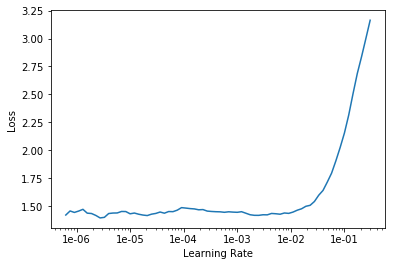

In [15]:
train_model(256, 3)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,5.484972,4.909328,0.946560,0.053440,01:56
1,4.776360,4.221008,0.874079,0.125921,01:55
2,4.151571,3.676981,0.790541,0.209459,01:55
3,3.724185,3.240266,0.738944,0.261057,01:54
4,3.291137,2.886745,0.688575,0.311425,01:55
5,3.042728,2.574174,0.625307,0.374693,01:54
6,2.758306,2.321647,0.578624,0.421376,01:54
7,2.477020,2.141530,0.537469,0.462531,01:54
8,2.330515,2.032857,0.516585,0.483415,01:56
9,2.138284,1.911215,0.482801,0.517199,01:55


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.423700,1.559031,0.412162,0.587838,01:59
1,2.275425,2.228308,0.558968,0.441032,01:59
2,2.202275,1.726194,0.471130,0.528870,01:59
3,1.667832,1.488464,0.406020,0.593980,02:00
4,1.221439,1.071108,0.299754,0.700246,01:58
5,0.843374,0.828841,0.232187,0.767813,01:59
6,0.608528,0.692664,0.199017,0.800983,01:58
7,0.434634,0.678000,0.190418,0.809582,01:59


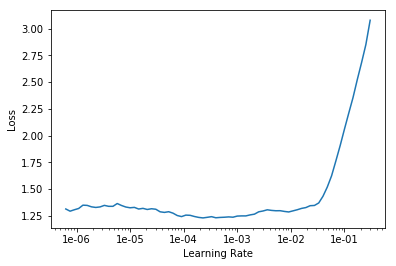

In [16]:
train_model(512, 4)

In [18]:
learn_50 = cnn_learner(get_data(256), models.resnet50, metrics=[error_rate, accuracy],
                      callbacks=[SaveModelCallback(learn_50, every='improvement',
                                                   monitor='accuracy', name='best_256')]).load('resnet50_128')

learn_50.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.053486,0.579820,0.167076,0.832924,01:54
1,1.171697,0.637224,0.192875,0.807125,01:54
2,1.009386,0.584632,0.171990,0.828010,01:54
3,0.783432,0.521231,0.162162,0.837838,01:54
4,0.740609,0.503757,0.152334,0.847666,01:54


Better model found at epoch 0 with accuracy value: 0.8329238295555115.
Better model found at epoch 3 with accuracy value: 0.837837815284729.
Better model found at epoch 4 with accuracy value: 0.8476658463478088.


In [19]:
learn_50 = cnn_learner(get_data(512), models.resnet50, metrics=[error_rate, accuracy],
                      callbacks=[SaveModelCallback(learn_50, every='improvement',
                                                   monitor='accuracy', name='best_512')]).load('best_256')

learn_50.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.807310,0.375301,0.101351,0.898649,01:54
1,0.972707,0.479386,0.136364,0.863636,01:53
2,0.824283,0.467318,0.140049,0.859951,01:54
3,0.781377,0.424629,0.119165,0.880835,01:54
4,0.670072,0.422577,0.123464,0.876536,01:52


Better model found at epoch 0 with accuracy value: 0.8986486196517944.


In [0]:
learn_50.load('best_512')
log_preds, test_labels = learn_50.get_preds(ds_type=DatasetType.Test)

**Prediction for the test dataset**

In [25]:
preds = np.argmax(log_preds, 1)
preds

tensor([  6, 187,  70,  ..., 142, 151,  39])